<a href="https://colab.research.google.com/github/Wanita-8943/Main_Project/blob/main/(1e-4)AC3_AllAge_Freeze_250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_All_Age_0.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07,0,V1.jpg,/content/drive/My Drive/TVT_All_Age/train/Y07/...,Female,Both
1,2,1,7,Y07,0,Flip_V1.jpg,/content/drive/My Drive/TVT_All_Age/train/Y07/...,Female,Both
2,3,2,7,Y07,0,V2.jpg,/content/drive/My Drive/TVT_All_Age/train/Y07/...,Female,Both
3,4,2,7,Y07,0,Flip_V2.jpg,/content/drive/My Drive/TVT_All_Age/train/Y07/...,Female,Both
4,5,3,7,Y07,0,V3.jpg,/content/drive/My Drive/TVT_All_Age/train/Y07/...,Female,Both
...,...,...,...,...,...,...,...,...,...
4745,121,77,25,Y25,18,Flip_J463.jpg,/content/drive/My Drive/TVT_All_Age/test/Y25/F...,Male,Both
4746,122,78,25,Y25,18,J464.jpg,/content/drive/My Drive/TVT_All_Age/test/Y25/J...,Male,Both
4747,123,78,25,Y25,18,Flip_J464.jpg,/content/drive/My Drive/TVT_All_Age/test/Y25/F...,Male,Both
4748,124,79,25,Y25,18,J465.jpg,/content/drive/My Drive/TVT_All_Age/test/Y25/J...,Male,Both


#Imports

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [5]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [6]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1079, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1079 (delta 121), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1079/1079), 13.94 MiB | 36.80 MiB/s, done.
Resolving deltas: 100% (618/618), done.
/content/efficientnet_keras_transfer_learning


In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

#load model 


In [8]:

import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/Classification/All_Age/AC2_AllAge_Freeze_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})
    

In [9]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/cut_panoramic/Model/Classification/All_Age/AC2_AllAge_Freeze_250.h5')
height = width = model.input_shape[1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
Total params: 4,073,903
Trainable params: 24,339
Non-trainable params: 4,049,564
_________________________________________________________________


#สร้างโฟลเดอร์ Train Valodation และ Test

In [11]:
base_dir = '/content/drive/MyDrive/TVT_All_Age'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)


#Train

In [12]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2850 images belonging to 19 classes.
Found 950 images belonging to 19 classes.


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-13-f67d4bb4808f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 200s 1s/step - loss: 2.6062 - acc: 0.2459 - val_loss: 4.2217 - val_acc: 0.1949
Epoch 2/250
178/178 [==============================] - 24s 131ms/step - loss: 2.5950 - acc: 0.2421 - val_loss: 4.2842 - val_acc: 0.1780
Epoch 3/250
178/178 [==============================] - 24s 134ms/step - loss: 2.6194 - acc: 0.2512 - val_loss: 4.2005 - val_acc: 0.1864
Epoch 4/250
178/178 [==============================] - 25s 138ms/step - loss: 2.6534 - acc: 0.2350 - val_loss: 4.0662 - val_acc: 0.1886
Epoch 5/250
178/178 [==============================] - 24s 132ms/step - loss: 2.5870 - acc: 0.2410 - val_loss: 4.1118 - val_acc: 0.1864
Epoch 6/250
178/178 [==============================] - 24s 134ms/step - loss: 2.5894 - acc: 0.2421 - val_loss: 4.1038 - val_acc: 0.1737
Epoch 7/250
178/178 [==============================] - 24s 135ms/step - loss: 2.5855 - acc: 0.2371 - val_loss: 4.0455 - val_acc: 0.1790
Epoch 8/250
178/178 [=============================

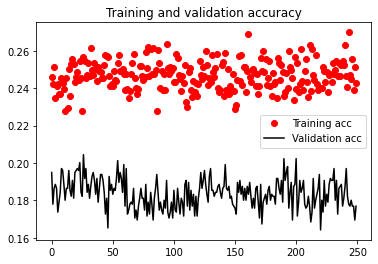

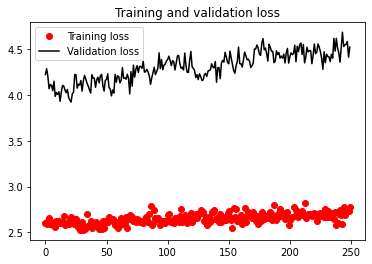

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'ro', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'ro', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [15]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/MyDrive/cut_panoramic/Model/Classification/All_Age/(1e-4)AC3_AllAge_Freeze_250.h5')

In [16]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1_รอบแรก_Gender_250.h5')